Exercise 11: Low-rank approximations in the Ising model
====================================
<img src="ising.png" style="max-width:30%; float:right; padding-left:30pt">

Let us return to our study of the [Ising model]. As reminder: the Ising model is a $N \times N$
(in our case `40 x 40`) square grid of Ising spins, $\sigma_{i,j}$, which can either be $+1$ or $-1$
at any given moment.  The potential energy $U$ encoded in each configuration is given by:
$$
   U = -\sum_{i,j} \big[ \sigma_{i,j} \sigma_{i,j+1} + \sigma_{i,j} \sigma_{i+1,j} \big],
$$
which is competing with the kinetic energy due to temperature $T$, which is randomly flipping spins.

The dataset is almost the same as for the last exercise, but I have split it by temperature: there
are $N_T = 10$ temperatures, $T = 0.25, 0.5, \ldots, 3.75$, stored in the array `temp`.
For each temperature, there are $N = 16000$
observations, so the `spins` tensor is now of shape $N_T \times N \times L \times L$.

The idea of this lecture is to explore different low-rank approximations to this tensor.

[Ising model]: https://en.wikipedia.org/wiki/Ising_model


In [24]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [25]:
# Load the dataset from a binary file
with np.load(os.path.expanduser("~/shared/ising.npz")) as _datafile:
    spins = _datafile["spins"].reshape(10, 16_000, 40, 40)
    temp = _datafile["temp"][::16_000]

In [26]:
spins.shape

(10, 16000, 40, 40)

In [27]:
temp

array([0.25, 0.5 , 1.  , 1.25, 1.75, 2.25, 2.5 , 3.  , 3.25, 3.75])

In [28]:
temp.shape

(10,)

Part 1. Compressing the design matrix for low T
--------------------------------
First, let us analyze the singular value decomposition of the "design matrices" $X$
for each temperature.

For this, make a new tensor `X`, which contains all 10 temperatures.  It should "flatten" out the
grid of spins into a single dimension.  In other words, the spins are the features in our design
matrix.

Also, restrict yourself to the first 1,000 observations in each temperature (otherwise the SVD will
become too expensive)

In [29]:
N_T = 10
N = 1000

X = spins[:, :N, :, :].reshape(N_T, N, -1)

In [30]:
X.shape

(10, 1000, 1600)

In [31]:
assert X.shape == (10, 1000, 1600)


Perform a **thin SVD** of the design matrix for $T = 1.75$.
Plot the singular values on a logarithmic scale.

Reminder: thin SVDs can be computed by passing `full_matrices=False`.

In [32]:
temperature_index = 4

U, S, V = np.linalg.svd(X[temperature_index], full_matrices=False)


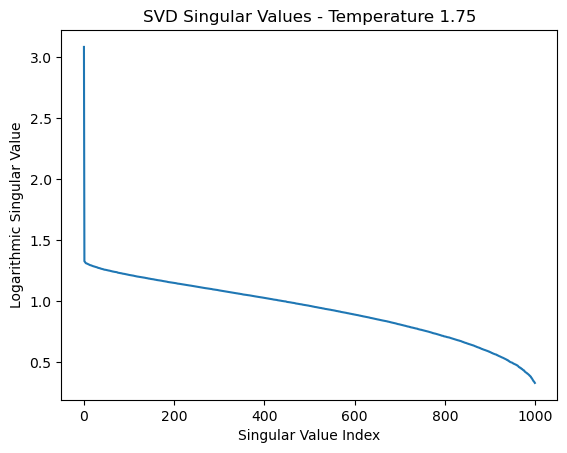

In [33]:
plt.plot(np.log10(S))
plt.xlabel('Singular Value Index')
plt.ylabel('Logarithmic Singular Value')
plt.title(f'SVD Singular Values - Temperature 1.75')
plt.show()

Let us now do a truncated SVD approximation: 
$$ 
\hat X_K = \sum_{k=0}^{K-1} s_k \vec u_k \vec v_k^T
$$
with $K = 1$ (rank-1 approximation). Compute this approximation and store it in `X1`.

Also, infer the relative error of this approximation
$$
    \epsilon_1 = \frac{\Vert X - \hat X_1\Vert}{\Vert X\Vert}
$$
and print it.  Compute this quantity **only** from the singular values.

In [34]:
K = 1  

U_k = U[:, :K]
S_k = np.diag(S[:K])
V_k = V[:K, :]

X1 = U_k.dot(S_k).dot(V_k)

epsilon_1 = np.linalg.norm(X - X1) / np.linalg.norm(X)
diff = 0.5*(X-X1)

print(f'Relative Error (Rank-1 approximation): {epsilon_1}')


Relative Error (Rank-1 approximation): 1.3193196304839658


In [35]:
assert X1.shape == (1000, 1600)
assert np.allclose(X1 / X1[:1], X1[:,:1] / X1[0,0]), "not rank-1"
assert np.allclose(X1 / X1[:,:1], X1[:1] / X1[0,0]), "not rank-1"

Let us now analyze this approximation visually. Make a figure with three false color plots
as subplots, showing the following:

 1. the actual design matrix $X$
 2. the rank-1 approximation $\hat X_1$
 3. the difference: $\tfrac12 (X - \hat X_1)$. (the one-half is there so that the result is again in the range $[-1,1]$).
 
Add titles and a colorbar (include a label for the colorbar too).

Hint: I find plotting this with the `'binary'` colormap gives a most appealing picture, but you can use any one.

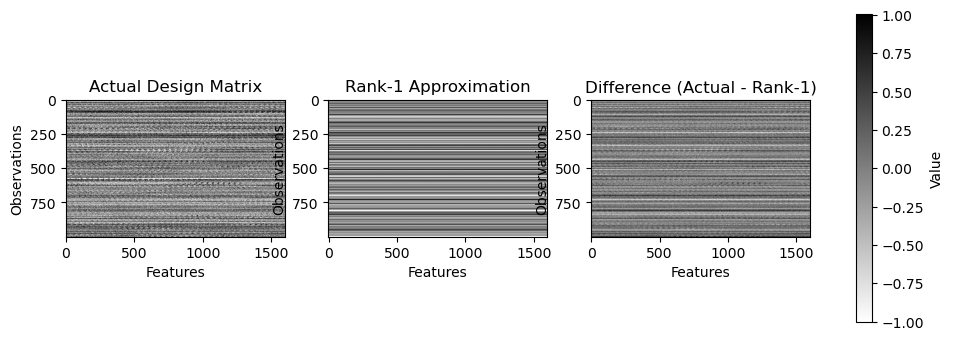

In [36]:
X_reshape = X[5,:,:]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))


ax1 = axes[0]
ax1.imshow(X_reshape, cmap='binary')
ax1.set_title('Actual Design Matrix')
ax1.set_xlabel('Features')
ax1.set_ylabel('Observations')


ax2 = axes[1]
ax2.imshow(X1, cmap='binary')
ax2.set_title('Rank-1 Approximation')
ax2.set_xlabel('Features')
ax2.set_ylabel('Observations')

ax3 = axes[2]
ax3.imshow(diff[5], cmap='binary')
ax3.set_title('Difference (Actual - Rank-1)')
ax3.set_xlabel('Features')
ax3.set_ylabel('Observations')


cbar = fig.colorbar(ax3.imshow(diff[5], cmap='binary'), ax=axes)
cbar.set_label('Value')


#plt.tight_layout()


plt.show()


Let us analyze these plots:

 1. Observe the data $X$ mostly consists of "stripes".  Translate these back to our field
    of Ising spins: what does these stripes correspond to?  How is this related to
    the chosen temperature? (Hint: think about the last exercise)
    
 2. Now lets talk about the model $\hat X_1$. How do the dominant left ($u_k$) and right ($v_k$) 
    singular vector relate to the spin configurations?
    
 3. Using the previous points, explain why the model has such a good performance in this case.
    What is "missing"?

1. The "stripes" in the data correspond to the spatial correlations between neighboring spins in the Ising model. Each stripe represents a region where the spins tend to align in a particular direction. At higher temperatures, the system is more disordered, and the stripes may become less pronounced or even disappear. At lower temperatures, the system exhibits more ordered patterns, resulting in more pronounced stripes.

2. In the rank-1 approximation model, the dominant left singular vector (u_k) and right singular vector (v_k) provide information about the spatial patterns or configurations of the spins. The dominant left singular vector (u_k) captures the spatial pattern or configuration of spins that contributes the most to the variability in the data. It represents a common spatial pattern shared by the spin configurations in the dataset. The dominant right singular vector (v_k) indicates the contribution of this spatial pattern to each individual spin configuration.

3. The good performance of the rank-1 approximation model can be attributed to the fact that the dominant left singular vector (u_k) captures the most important spatial pattern or configuration of the spins that contributes to the variability in the data. By approximating the data using only this dominant pattern, the model can effectively capture the main features of the data and achieve a good reconstruction. It misses other spatial correlations or configurations that contribute to the finer details or higher-order variability in the data.

Part 2. Compressing the design matrix for higher T
----------------------------------------
Let us redo our analysis for $T = 2.5$.

Again perform a singular value decomposition of the design matrix $X$ for $T = 2.5$.
(You may want to use different variables for the result of the SVD).

Make a plot with two lines, one for the previous case ($T = 1.75$), one for this case.
In both cases plot the **normalized** singular values $s_k/s_0$ on a log scale.

Observe the very different behaviour.  Also, print the relative error
of a rank-1 approximation.

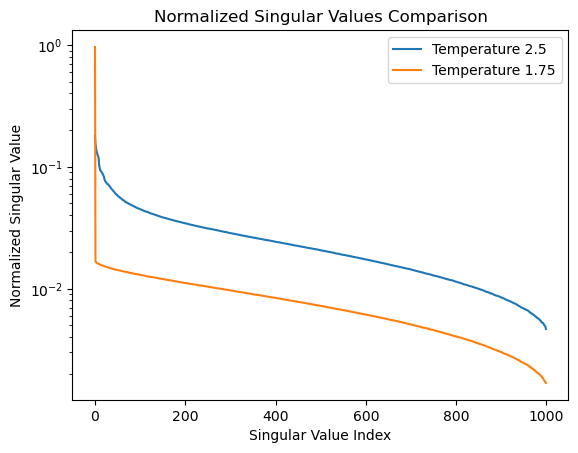

Relative error for rank-1 approximation (Temperature 5): 1.3833112531547438


In [37]:

U_2, S_2, VT_2 = np.linalg.svd(X[6], full_matrices=False)

normalized_singular_values = S_2 / np.linalg.norm(S_2)
normalized_singular_values_1 = S / np.linalg.norm(S)

plt.semilogy(normalized_singular_values, label='Temperature 2.5')


plt.semilogy(normalized_singular_values_1, label='Temperature 1.75')


plt.xlabel('Singular Value Index')
plt.ylabel('Normalized Singular Value')
plt.title('Normalized Singular Values Comparison')
plt.legend()


plt.show()

K = 1
X1_temp_idx = U[:, :K] @ np.diag(S[:K]) @ VT_2[:K, :]

error_temp_idx = np.linalg.norm(X[6] - X1_temp_idx) / np.linalg.norm(X[6])

print(f'Relative error for rank-1 approximation (Temperature 5): {error_temp_idx}')


Since a rank-1 approximation is so poor, let us construct a **rank-10**
approxiamtion $\hat X_{10}$ to this higher temperature case.
Store this approximation in `Xhat`.

Afterwards, repeat the false color plot with the three panels of data, model
and difference in this case.

In [38]:
temp_idx = 6
Xhat, S_temp_idx, VT_temp_idx = np.linalg.svd(X[temp_idx], full_matrices=False)
Xhat_temp_idx = Xhat[:, :K] @ np.diag(S_temp_idx[:K]) @ VT_temp_idx[:K, :]



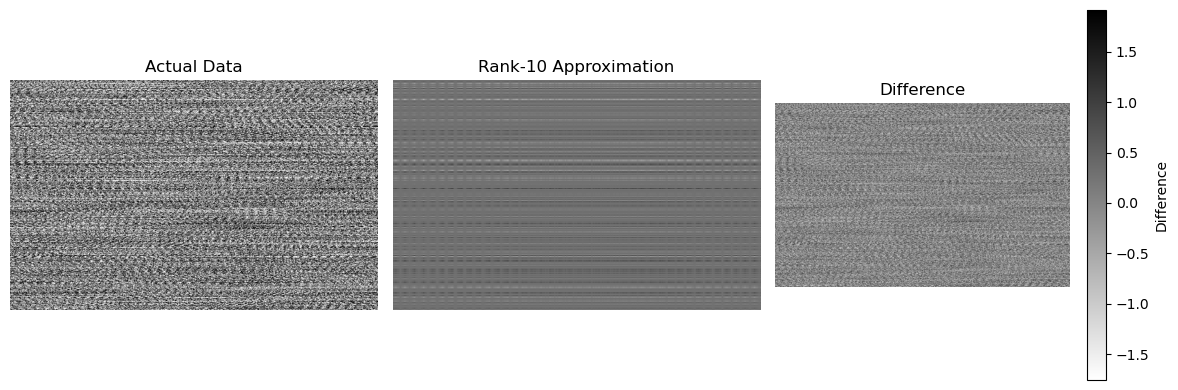

In [39]:

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(X[temp_idx], cmap='binary')
axes[0].set_title('Actual Data')
axes[0].axis('off')

axes[1].imshow(Xhat_temp_idx, cmap='binary')
axes[1].set_title('Rank-10 Approximation')
axes[1].axis('off')

difference_temp_idx = X[temp_idx] - Xhat_temp_idx
axes[2].imshow(difference_temp_idx, cmap='RdYlBu', vmin=-0.5, vmax=0.5)
axes[2].set_title('Difference')
axes[2].axis('off')

cbar = fig.colorbar(axes[2].imshow(difference_temp_idx, cmap='binary'))
cbar.set_label('Difference')

plt.tight_layout()

plt.show()


Let us analyze the data:

 1. First, compare the data to the low-temperature case above. What changed?

 2. Think of the data $X$ (first panel) as the sum of model plus difference (other panels).
    Which qualitative features of the data are captured by the model, and what mainly is "left over"?
    
 3. Observe that the singular values of $X$ decay very differently in the case of
    the ordered phase and the disordered phase.  Discuss the implications of this
    for "compressing" the data.  Use it to resolve the following apparent contradiction: 
    **"Randomness is information"**.
    

1. In the low-temperature case, the data shows clear stripe patterns corresponding to the ordered phase of the Ising spins. In contrast, the high-temperature case shows a more random and disordered pattern.

2. The model captures the overall statistical properties of the datah. However, the model is not able to capture the fine details and local structures present in the data. It doesn't capture the noise and random variations present in the system.

3. The decay of singular values in the high-temperature case indicates that there is less correlation and structure in the data compared to the low-temperature case. Randomness can still contain information, but it may require more complex models to capture that information accurately. In the disordered phase, the randomness represents the inherent fluctuations and uncertainty in the system.

Part 3: Principal Component Analysis
------------------------------------------------

Finally, let us perform a Principal Component Analysis (PCA).
For this, we are going to use sklearn again, specifically the [PCA]
class.

Use the design matrix for $T = 1.75$ and perform a PCA with two
components.

[PCA]: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [40]:
from sklearn.decomposition import PCA

In [41]:

X_T175 = X[4]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_T175)

principal_components = pca.components_

explained_variance_ratio = pca.explained_variance_ratio_

print("Explained Variance Ratio:", explained_variance_ratio)


Explained Variance Ratio: [9.28117253e-01 2.73692171e-04]


Reduce the design matrix $X$ to the principal space $\tilde X = X W$
and store it in `Xred`. Now the two features left (i.e., the two columns
of `Xred`) correspond to the two "dominant" features, also known as
*principal components*.

**Hint**: The matrix $W^T$ is is stored as `components_` in the PCA class. Note the transpose!

In [42]:

Xred = X_T175.dot(principal_components.T)

Xred.shape


(1000, 2)

In [43]:
assert Xred.shape == (1000, 2)
np.testing.assert_allclose(
    np.linalg.svd(Xred, compute_uv=False), [1220, 21], rtol=3e-1)

Let's analyze our principal components in `Xred`.

Make a 2D scatter plot, where each observation is again a point,
the first component refers to the first principal component and
the second component to the second principal component.

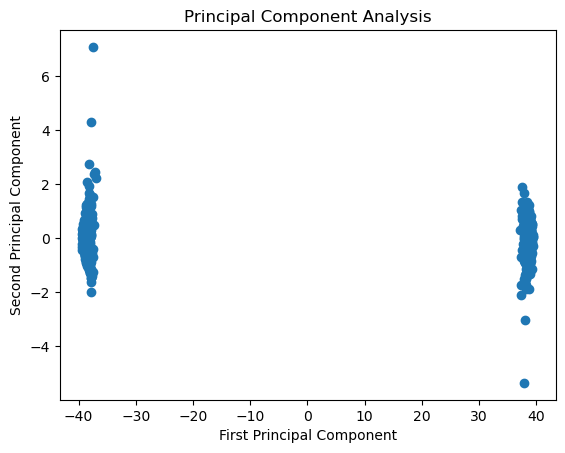

In [44]:

component_1 = Xred[:, 0]
component_2 = Xred[:, 1]

plt.scatter(component_1, component_2)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("Principal Component Analysis")
plt.show()


Copy the previous two answers, i.e., the computation of `Xred` and the plot, from above, 
but alter it as follows: instead of projecting the results for $T = 1.75$ on
its own principal components, see what happens if you project the design matrix `X` for $T = 3.75$
(the highest temperature) onto the principal components for $T = 1.75$.

In other words, **do not** recompute the PCA, just redo the projection
and the plot.

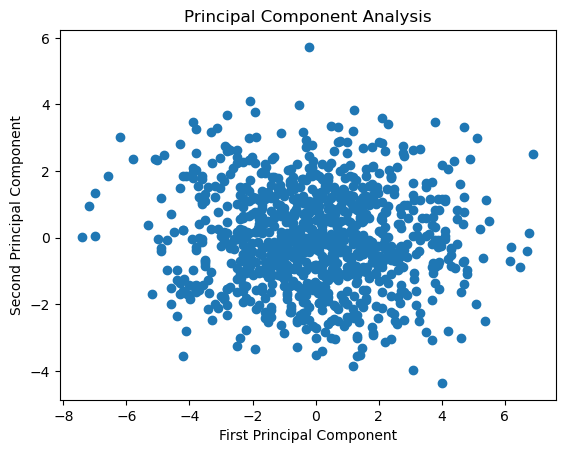

In [45]:
X_T375 = X[9]

Xred375 = X_T375.dot(principal_components.T)

Xred375.shape

component_1 = Xred375[:, 0]
component_2 = Xred375[:, 1]

plt.scatter(component_1, component_2)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("Principal Component Analysis")
plt.show()

Observe that the distribution of points, particularly for the first principal component of 
the low-temperature case completely changes when we heat up the system.

Use this to speculate on what the first principal component may mainly correspond to 
(in terms of spin configurations)?

Its possible that the first principal component may correspond to the presence or absence of specific spin configurations or patterns that are characteristic of the low-temperature regime. It could potentially capture information about the degree of order or disorder in the spin system, as higher temperatures tend to disrupt the ordered arrangements and introduce more randomness.